In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import scanpy as sc
import anndata as ad
import muon as mu
from muon import MuData 
import mofax as mfx
import mofapy2
from mofapy2.run.entry_point import entry_point


from gprofiler import GProfiler

In [ ]:
path_mdata = "/home/azureuser/PROJECTS_ALL/DATA_Glioblastoma/preprocessed/mdata_preprocessed_v.h5ad"
mdata = mu.read_h5mu(path_mdata)

In [ ]:

# MOFA model
model = entry_point()

model.set_data_options(
    scale_views=True,
    scale_groups=False
)

anndatas = [rna_adata, prot_adata, methylation_ad]
for adata in anndatas:
    model.set_data_from_anndata(adata)




        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...

Loaded view='rna' group='group1' with N=97 samples and D=1104 features...


Loaded view='rna' group='group1' with N=97 samples and D=5723 features...


Loaded view='rna' group='group1' with N=97 samples and D=707 features...




In [ ]:
#  model options
model.set_model_options(
    factors=10,
    spikeslab_weights=True,
    ard_factors=True
)

#  training options
model.set_train_options(
    iter=1000,
    convergence_mode="medium",
    seed=1
)

model.build()
model.run()
model.save("gbm_mofa_model___.hdf5")

Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (rna): gaussian




######################################
## Training the model with seed 1 ##
######################################


ELBO before training: -553320.57 

Iteration 1: time=0.03, ELBO=-96075.63, deltaELBO=457244.943 (82.63653388%), Factors=10
Iteration 2: time=0.03, ELBO=-70004.28, deltaELBO=26071.354 (4.71179920%), Factors=10
Iteration 3: time=0.03, ELBO=-53770.01, deltaELBO=16234.270 (2.93397188%), Factors=10


Iteration 4: time=0.04, ELBO=-44842.57, deltaELBO=8927.438 (1.61342955%), Factors=10
Iteration 5: time=0.03, ELBO=-40523.59, deltaELBO=4318.980 (0.78055653%), Factors=10
Iteration 6: time=0.03, ELBO=-39105.85, deltaELBO=1417.736 (0.25622320%), Factors=10
Iteration 7: time=0.03, ELBO=-38366.48, deltaELBO=739.369 (0.13362397%), Factors=10
Iteration 8: time=0.03, ELBO=-37929.64, deltaELBO=436.846 (0.07894989%), Factors=10
Iteration 9: time=0.03, ELBO=-37654.10, deltaELBO=275.540 (0.04979758%), Factors=10
Iteration 10: time=0.03, ELBO=-37467.05, deltaELBO=187.052 (0.03380535%), Factors=10
Iteration 11: time=0.03, ELBO=-37321.65, deltaELBO=145.393 (0.02627636%), Factors=10
Iteration 12: time=0.03, ELBO=-37182.98, deltaELBO=138.673 (0.02506200%), Factors=10
Iteration 13: time=0.03, ELBO=-37020.85, deltaELBO=162.130 (0.02930133%), Factors=10
Iteration 14: time=0.03, ELBO=-36800.24, deltaELBO=220.614 (0.03987101%), Factors=10
Iteration 15: time=0.03, ELBO=-36466.27, deltaELBO=333.965 (0.060356

In [87]:
modell = mfx.mofa_model("gbm_mofa_model___.hdf5")

In [ ]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata)
sc.tl.leiden(mdata)

sc.pl.umap(mdata, color="leiden", save="mofa2_umap_gbm_leiden.png")

No significant enrichment for Factor_1


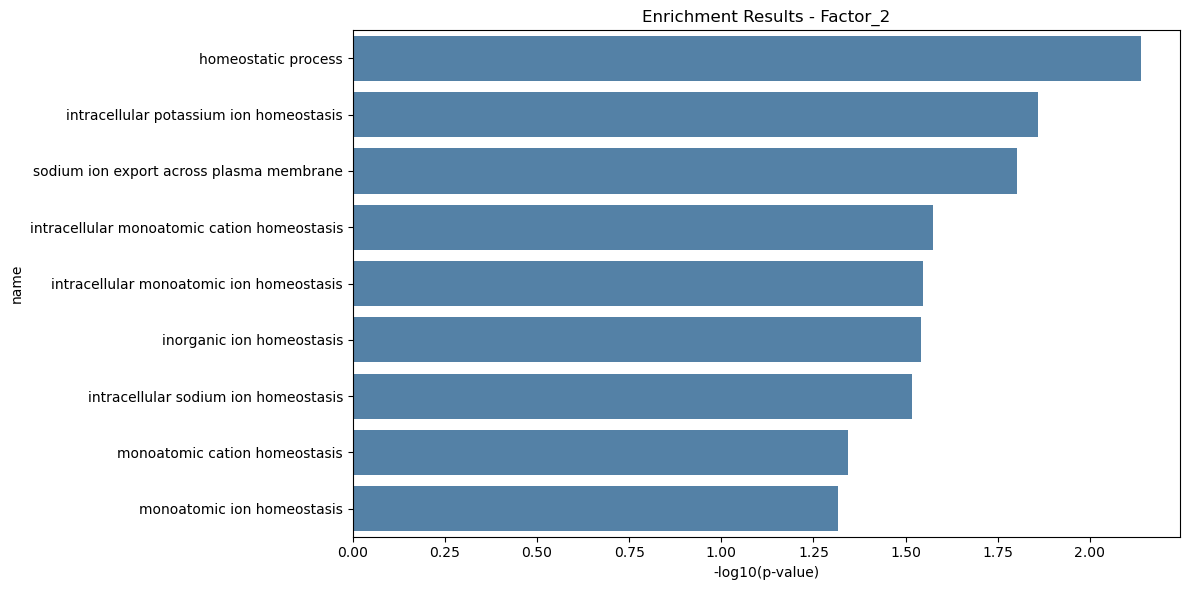

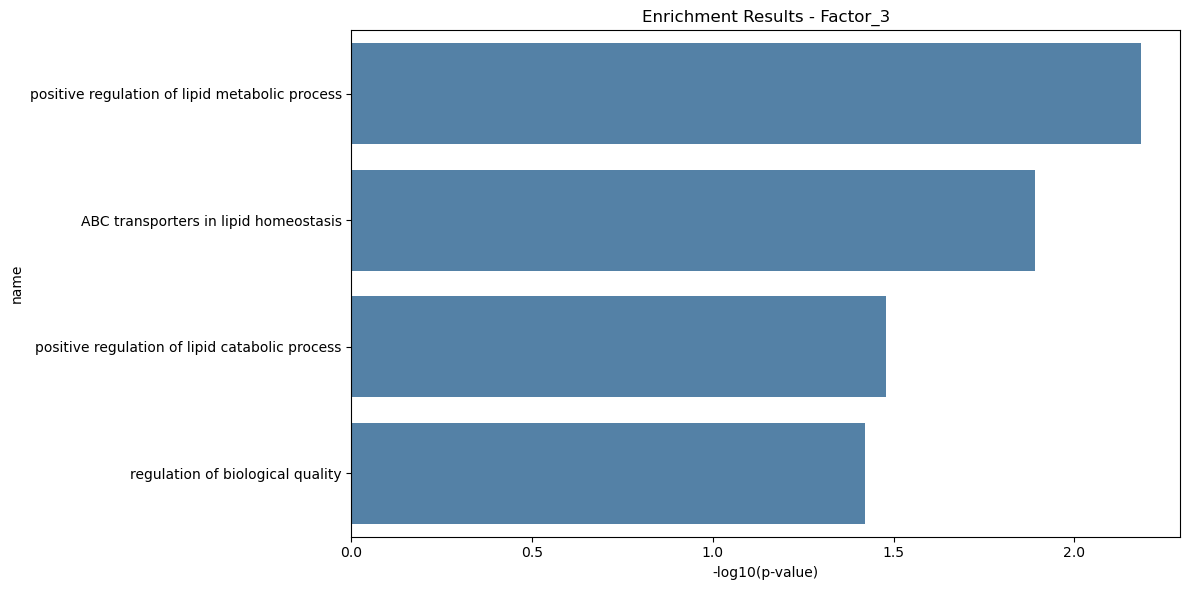

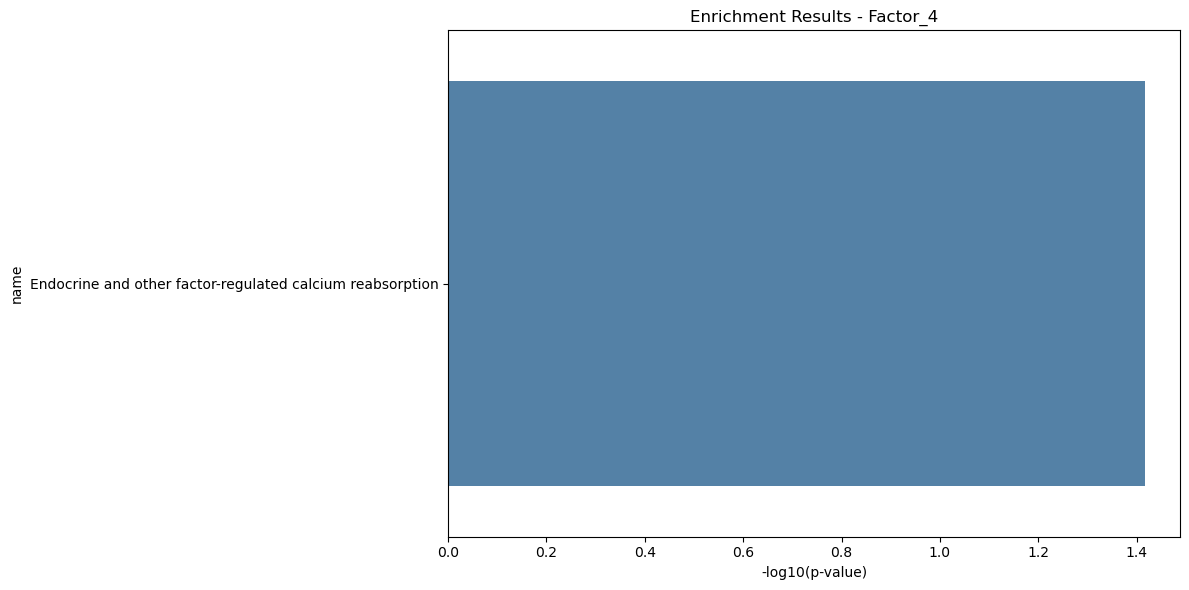

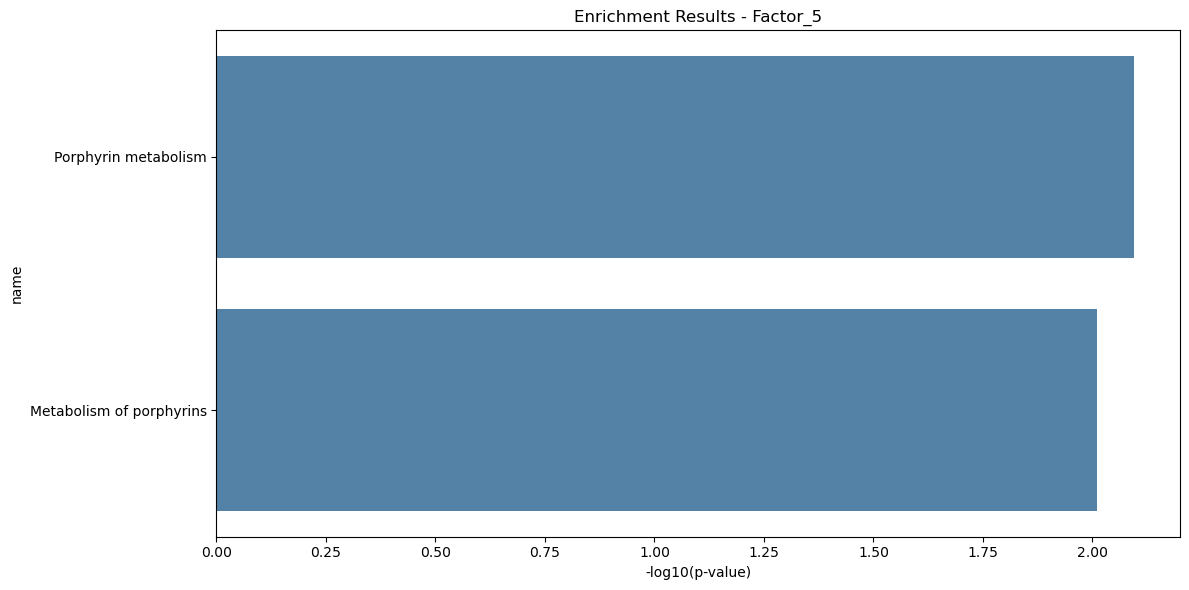

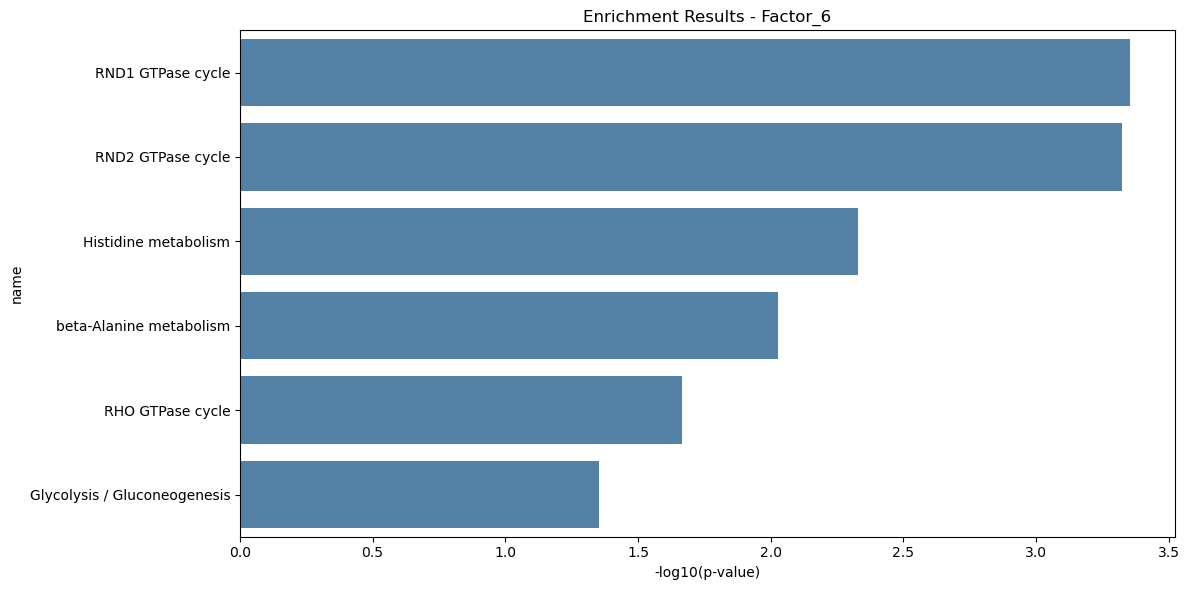

No significant enrichment for Factor_7


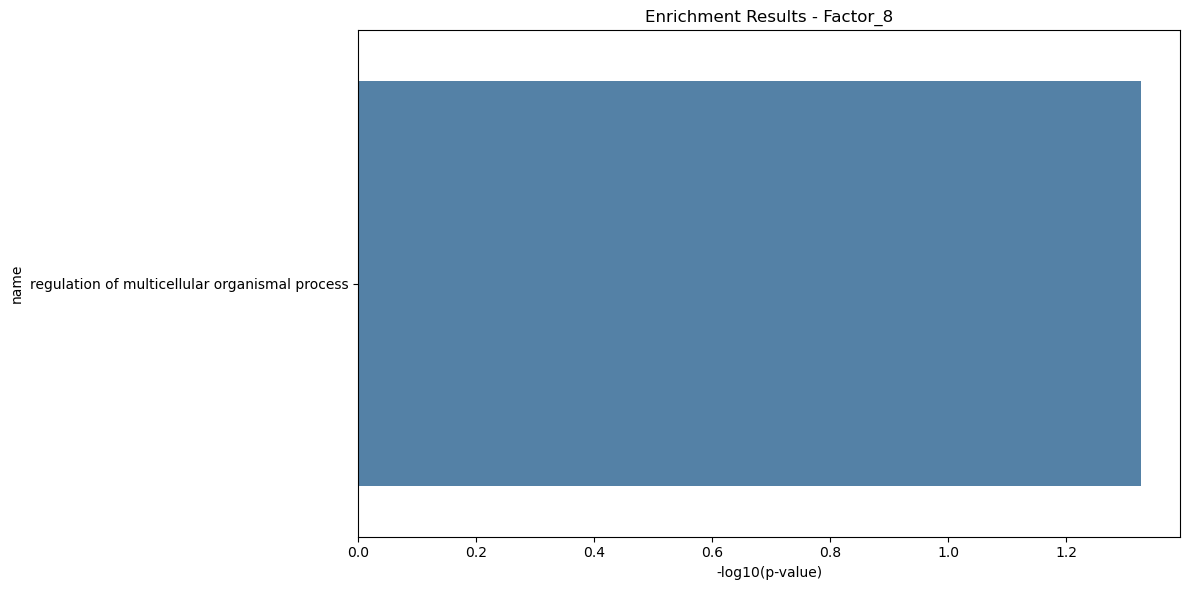

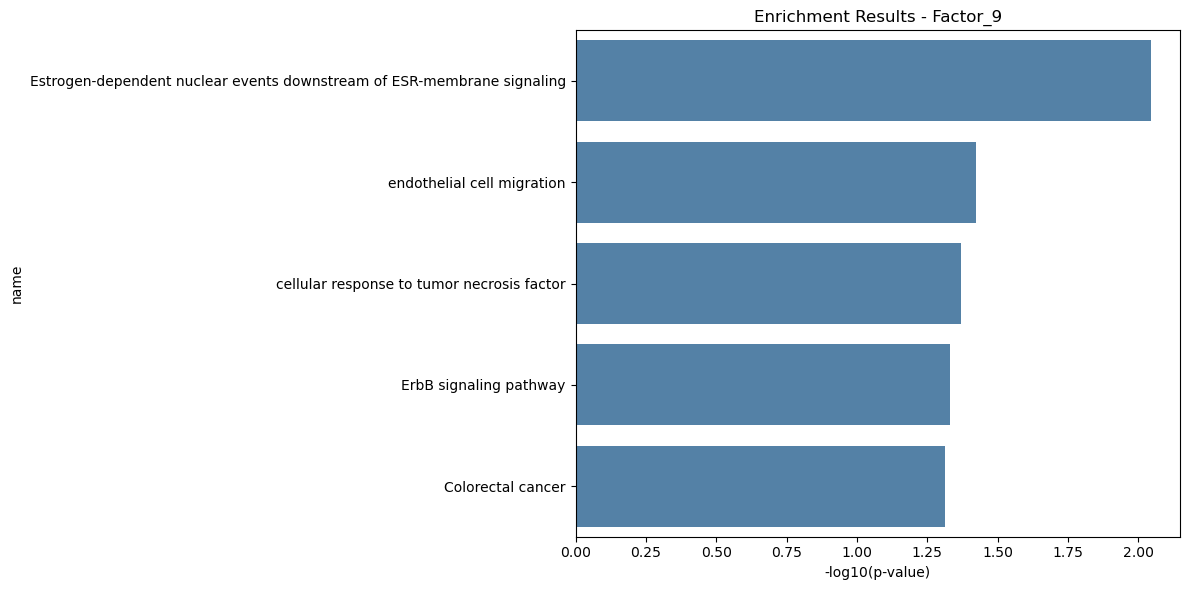

No significant enrichment for Factor_10


In [89]:

def process_mofa_weights(model):
    weights = model.get_weights()
    weights_df = pd.DataFrame(weights)
    return weights_df

def get_top_features(weights_df, n_features=10):
    top_features = {}
    for factor in range(weights_df.shape[1]):
        # absolute weights
        abs_weights = np.abs(weights_df.iloc[:, factor])
        # top features
        top_indices = abs_weights.nlargest(n_features).index
        top_features[f"Factor_{factor+1}"] = top_indices.tolist()
    return top_features


def run_enrichment(features_dict):
    gp = GProfiler(return_dataframe=True)
    enrichments = {}
    
    for factor, genes in features_dict.items():
        try:
            results = gp.profile(
                query=genes,
                organism='hsapiens',
                sources=['GO:BP', 'KEGG', 'REAC'],
                user_threshold=0.05
            )
            # Add -log10(p-value) column
            results['neglog10pval'] = -np.log10(results['p_value'])
            enrichments[factor] = results
        except Exception as e:
            print(f"Error in enrichment for {factor}: {str(e)}")
            enrichments[factor] = pd.DataFrame()
            
    return enrichments

# Visualization function
def plot_enrichment(factor, results, top_n=10):
    if len(results) == 0:
        print(f"No significant enrichment for {factor}")
        return
        
    plt.figure(figsize=(12, 6))
    plot_df = results.nsmallest(top_n, 'p_value')
    
    sns.barplot(data=plot_df, 
                y='name',
                x='neglog10pval',
                color='steelblue')
    
    plt.title(f'Enrichment Results - {factor}')
    plt.xlabel('-log10(p-value)')
    plt.tight_layout()
    plt.show()

# Execute analysis
weights_df = process_mofa_weights(modell)
top_features = get_top_features(weights_df)
enrichment_results = run_enrichment(top_features)

# Plot results
for factor, results in enrichment_results.items():
    plot_enrichment(factor, results)


---

### **Interpretation of MOFA Enrichment Results**
MOFA (Multi-Omics Factor Analysis) identifies latent factors associated with variation in multi-omics data. Enrichment analysis links these factors to known biological processes, pathways, and molecular functions. Below is a factor-wise discussion of the results:

---

### **Factor 2: Ion Homeostasis**
Enriched terms in **Factor 2** are dominated by processes related to ion homeostasis:
- **Top pathways**: *Intracellular potassium ion homeostasis*, *sodium ion export across the plasma membrane*, *monoatomic ion homeostasis*.
- **Biological relevance**:
  - Ion homeostasis is crucial for cellular functions, including maintaining membrane potential, intracellular signaling, and transport processes.
  - Disruption in ion channels and transporters is a hallmark of many cancers, including breast cancer, influencing processes like cell proliferation, apoptosis, and migration.
- **Implications**: 
  - Factor 2 likely captures variation in ion-channel-related genes or proteins, which may be driving differences in tumor microenvironments or cellular stress responses.

---

### **Factor 3: Lipid Metabolism**
- **Top pathways**: *Positive regulation of lipid metabolic processes*, *ABC transporters in lipid homeostasis*.
- **Biological relevance**:
  - Lipid metabolism is often reprogrammed in cancer cells to support rapid growth, membrane synthesis, and energy production.
  - ABC transporters are linked to drug resistance and are involved in lipid transport and efflux mechanisms in tumor cells.
- **Implications**:
  - Factor 3 highlights metabolic rewiring in breast cancer, specifically lipid catabolism and regulation.

---

### **Factor 4: Calcium Reabsorption**
- **Top pathway**: *Endocrine and other factor-regulated calcium reabsorption*.
- **Biological relevance**:
  - Calcium signaling is vital for cellular processes like proliferation, migration, and apoptosis.
  - Dysregulated calcium homeostasis is a hallmark of metastatic cancers, where it can modulate the epithelial-to-mesenchymal transition (EMT) and angiogenesis.
- **Implications**:
  - Factor 4 may capture mechanisms related to calcium dynamics in breast cancer progression.
---

### **Factor 5: Porphyrin Metabolism**
- **Top pathways**: *Porphyrin metabolism*, *Metabolism of porphyrins*.
- **Biological relevance**:
  - Porphyrin metabolism is integral to heme synthesis, essential for oxygen transport and cytochrome function.
  - Dysregulation of heme metabolism can affect oxidative stress and hypoxia, critical factors in tumor growth.
- **Implications**:
  - Porphyrin-related processes might identify tumor subtypes that rely on altered heme synthesis.
---

### **Factor 6: GTPase Cycles and Metabolism**
- **Top pathways**: *RND GTPase cycles*, *Histidine metabolism*, *Beta-alanine metabolism*.
- **Biological relevance**:
  - Rho-family GTPases (RND1, RND2) regulate cytoskeletal organization, cell migration, and invasion, processes critical in metastasis.
  - Histidine and beta-alanine metabolism may indicate metabolic dependencies in aggressive tumor phenotypes.
- **Implications**:
  - Factor 6 reflects cytoskeletal dynamics and altered metabolism, emphasizing tumor motility and metabolic adaptation.
---

### **Factor 8: Multicellular Processes**
- **Top pathway**: *Regulation of multicellular organismal processes*.
- **Biological relevance**:
  - Broad pathways involving intercellular communication, tissue organization, and systemic signaling.
  - Likely reflects interactions within the tumor microenvironment, including immune infiltration or stromal remodeling.

---

### **Factor 9: Cancer-Specific Signaling**
- **Top pathways**: *Estrogen signaling*, *Endothelial cell migration*, *ErbB signaling*.
- **Biological relevance**:
  - These pathways are pivotal in breast cancer, particularly in hormone receptor-positive subtypes (e.g., ER-positive).
  - Endothelial migration links to angiogenesis, necessary for tumor vascularization.
  - ErbB signaling (including HER2) is a major oncogenic driver in certain breast cancer subtypes.
- **Implications**:
  - Factor 9 captures oncogenic signaling and vascularization processes, directly linked to cancer progression and therapy resistance.
---
